# Intro to Stats Learning

## Lab 5

### Lab 5 - Cross validation and the bootstrap

> https://juliaai.github.io/DataScienceTutorials.jl/isl/lab-5/
> <br> **(project folder)** https://raw.githubusercontent.com/juliaai/DataScienceTutorials.jl/gh-pages/__generated/ISL-lab-5.tar.gz

In [1]:
using Pkg; Pkg.activate("D:/JULIA/6_ML_with_Julia/ISL-lab-5"); Pkg.instantiate()

  Activating project at `D:\JULIA\6_ML_with_Julia\ISL-lab-5`


> Getting started
>  1. Polynomial regression <br>

> K-Folds Cross Validation <br>
> The Bootstrap

### Getting started
---

In [2]:
using MLJ
import RDatasets: dataset
import DataFrames: DataFrame, select

auto = dataset("ISLR", "Auto")
y, X = unpack(auto, ==(:MPG), col -> true) # y(목표변수)를 MPG로 놓는다는 의미
train, test = partition(eachindex(y), 0.5, shuffle = true, rng = 444);

Note the use of ```rng=``` to seed the shuffling of indices so that the results are reproducible.

In [3]:
?unpack

search: unpack UnsupervisedAnnotatorComposite



```
unpack(table, f1, f2, ... fk;
       wrap_singles=false,
       shuffle=false,
       rng::Union{AbstractRNG,Int,Nothing}=nothing,
       coerce_options...)
```

Horizontally split any Tables.jl compatible `table` into smaller tables or vectors by making column selections determined by the predicates `f1`, `f2`, ..., `fk`. Selection from the column names is without replacement. A *predicate* is any object `f` such that `f(name)` is `true` or `false` for each column `name::Symbol` of `table`.

Returns a tuple of tables/vectors with length one greater than the number of supplied predicates, with the last component including all previously unselected columns.

```
julia> table = DataFrame(x=[1,2], y=['a', 'b'], z=[10.0, 20.0], w=["A", "B"])
2×4 DataFrame
 Row │ x      y     z        w
     │ Int64  Char  Float64  String
─────┼──────────────────────────────
   1 │     1  a        10.0  A
   2 │     2  b        20.0  B

Z, XY, W = unpack(table, ==(:z), !=(:w))
julia> Z
2-element Vector{Float64}:
 10.0
 20.0

julia> XY
2×2 DataFrame
 Row │ x      y
     │ Int64  Char
─────┼─────────────
   1 │     1  a
   2 │     2  b

julia> W  # the column(s) left over
2-element Vector{String}:
 "A"
 "B"
```

Whenever a returned table contains a single column, it is converted to a vector unless `wrap_singles=true`.

If `coerce_options` are specified then `table` is first replaced with `coerce(table, coerce_options)`. See [`ScientificTypes.coerce`](@ref) for details.

If `shuffle=true` then the rows of `table` are first shuffled, using the global RNG, unless `rng` is specified; if `rng` is an integer, it specifies the seed of an automatically generated Mersenne twister. If `rng` is specified then `shuffle=true` is implicit.


### Polynomial regression

In [4]:
LR = @load LinearRegressor pkg = MLJLinearModels

import MLJLinearModels

┌ Info: For silent loading, specify `verbosity=0`. 
└ @ Main C:\Users\jeffr\.julia\packages\MLJModels\tMgLW\src\loading.jl:168


 ✔


MLJLinearModels.LinearRegressor

In this part we only build models with the ```Horsepower``` feature.

┌ Warning: `vendor()` is deprecated, use `BLAS.get_config()` and inspect the output instead
│   caller = npyinitialize() at numpy.jl:67
└ @ PyCall C:\Users\jeffr\.julia\packages\PyCall\L0fLP\src\numpy.jl:67


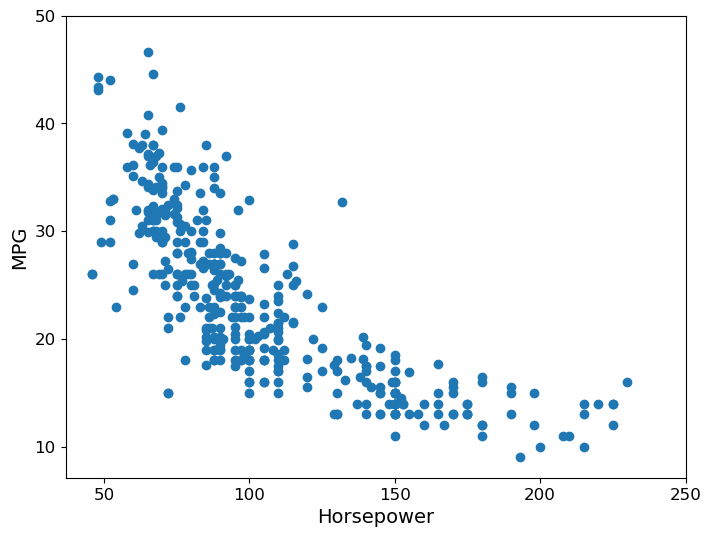

In [5]:
using PyPlot

figure(figsize = (8,6))
plot(X.Horsepower, y, ls ="none", marker = "o")

xlabel("Horsepower", fontsize = 14)
xticks(50:50:250, fontsize = 12)
yticks(10:10:50, fontsize = 12)
ylabel("MPG", fontsize = 14)

savefig("./plots/3.4.1.png")

Let's get a baseline:

In [6]:
lm = LR()
mlm = machine(lm, select(X, :Horsepower), y)
fit!(mlm, rows = train)
rms(MLJ.predict(mlm, rows = test), y[test])^2

┌ Info: Training Machine{LinearRegressor,…}.
└ @ MLJBase C:\Users\jeffr\.julia\packages\MLJBase\MuLnJ\src\machines.jl:464


23.493990895007997

Note that we square the measure to match the results obtained in the ISL labs where the mean squared error (here we use the ```rms``` which is the square root of that).

In [7]:
xx = (Horsepower = range(50, 225, length = 100) |> collect, )
yy = MLJ.predict(mlm, xx);

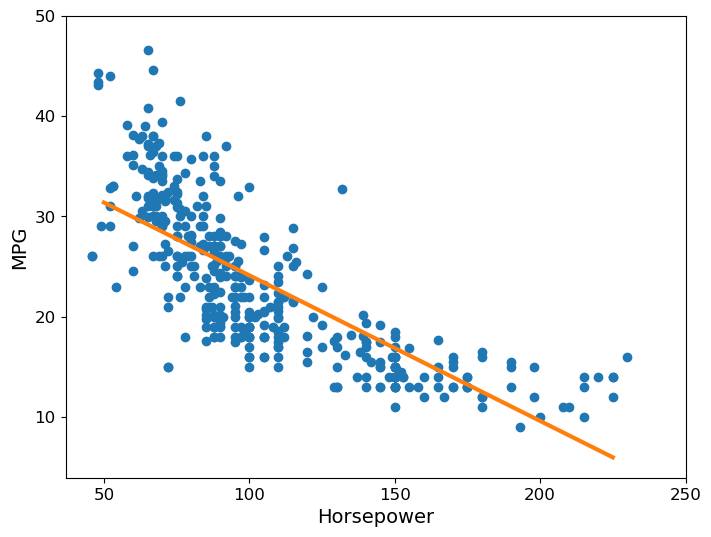

In [8]:
# plot
figure(figsize = (8, 6))
plot(X.Horsepower, y, ls = "none", marker = "o")
plot(xx.Horsepower, yy, lw = 3)

xlabel("Horsepower", fontsize = 14)
xticks(50:50:250, fontsize = 12)
yticks(10:10:50, fontsize = 12)
ylabel("MPG", fontsize = 14)

savefig("./plots/3.4.2.png")

We now want to build three polynomial models of degree 1, 2 and 3 respectively; we start by forming the corresponding feature matrix:

In [9]:
hp = X.Horsepower
Xhp = DataFrame(hp1 = hp, hp2 = hp.^2, hp3 = hp.^3);

Now we can write a simple pipeline where the first step selects the features we want(and with it the degree of the polynomial) and the second is the linear regressor:

In [10]:
LinMod = Pipeline(
    FeatureSelector(features = [:hp1]),
    LR()
    )

DeterministicPipeline(
    feature_selector = FeatureSelector(
            features = [:hp1],
            ignore = false),
    linear_regressor = LinearRegressor(
            fit_intercept = true,
            solver = nothing),
    cache = true)

Then we can instantiate and fit3 models where we specify the features each time:

In [11]:
# poly of degree 1 (line)

lr1 = machine(LinMod, Xhp, y) 
fit!(lr1, rows = train)

┌ Info: Training Machine{DeterministicPipeline{NamedTuple{,…},…},…}.
└ @ MLJBase C:\Users\jeffr\.julia\packages\MLJBase\MuLnJ\src\machines.jl:464
┌ Info: Training Machine{FeatureSelector,…}.
└ @ MLJBase C:\Users\jeffr\.julia\packages\MLJBase\MuLnJ\src\machines.jl:464
┌ Info: Training Machine{LinearRegressor,…}.
└ @ MLJBase C:\Users\jeffr\.julia\packages\MLJBase\MuLnJ\src\machines.jl:464


Machine{DeterministicPipeline{NamedTuple{,…},…},…} trained 1 time; caches data
  model: MLJBase.DeterministicPipeline{NamedTuple{(:feature_selector, :linear_regressor), Tuple{Unsupervised, Deterministic}}, MLJModelInterface.predict}
  args: 
    1:	Source @981 ⏎ `Table{AbstractVector{Continuous}}`
    2:	Source @784 ⏎ `AbstractVector{Continuous}`


In [12]:
# poly of degree 2
LinMod.feature_selector.features = [:hp1, :hp2]
lr2 = machine(LinMod, Xhp, y)
fit!(lr2, rows = train)

┌ Info: Training Machine{DeterministicPipeline{NamedTuple{,…},…},…}.
└ @ MLJBase C:\Users\jeffr\.julia\packages\MLJBase\MuLnJ\src\machines.jl:464
┌ Info: Training Machine{FeatureSelector,…}.
└ @ MLJBase C:\Users\jeffr\.julia\packages\MLJBase\MuLnJ\src\machines.jl:464
┌ Info: Training Machine{LinearRegressor,…}.
└ @ MLJBase C:\Users\jeffr\.julia\packages\MLJBase\MuLnJ\src\machines.jl:464


Machine{DeterministicPipeline{NamedTuple{,…},…},…} trained 1 time; caches data
  model: MLJBase.DeterministicPipeline{NamedTuple{(:feature_selector, :linear_regressor), Tuple{Unsupervised, Deterministic}}, MLJModelInterface.predict}
  args: 
    1:	Source @498 ⏎ `Table{AbstractVector{Continuous}}`
    2:	Source @802 ⏎ `AbstractVector{Continuous}`


In [13]:
# Poly of degree3
LinMod.feature_selector.features = [:hp1, :hp2, :hp3]
lr3 = machine(LinMod, Xhp, y)
fit!(lr3, rows = train)

┌ Info: Training Machine{DeterministicPipeline{NamedTuple{,…},…},…}.
└ @ MLJBase C:\Users\jeffr\.julia\packages\MLJBase\MuLnJ\src\machines.jl:464
┌ Info: Training Machine{FeatureSelector,…}.
└ @ MLJBase C:\Users\jeffr\.julia\packages\MLJBase\MuLnJ\src\machines.jl:464
┌ Info: Training Machine{LinearRegressor,…}.
└ @ MLJBase C:\Users\jeffr\.julia\packages\MLJBase\MuLnJ\src\machines.jl:464


Machine{DeterministicPipeline{NamedTuple{,…},…},…} trained 1 time; caches data
  model: MLJBase.DeterministicPipeline{NamedTuple{(:feature_selector, :linear_regressor), Tuple{Unsupervised, Deterministic}}, MLJModelInterface.predict}
  args: 
    1:	Source @679 ⏎ `Table{AbstractVector{Continuous}}`
    2:	Source @529 ⏎ `AbstractVector{Continuous}`


Let's check the performances on the test set

In [14]:
get_mse(lr) = rms(MLJ.predict(lr, rows = test), y[test])^2

@show get_mse(lr1)
@show get_mse(lr2)
@show get_mse(lr3)

get_mse(lr1) = 23.493990895007997
get_mse(lr2) = 19.287175510952146
get_mse(lr3) = 19.381831638657914


19.381831638657914

Let's visualise the models

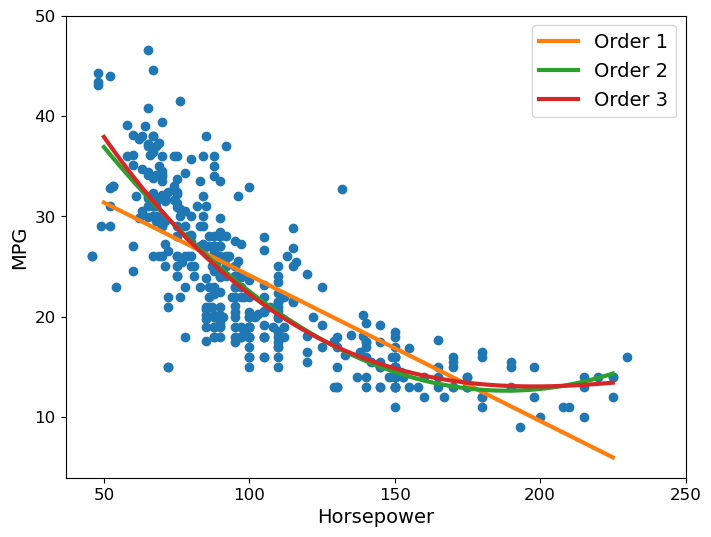

In [15]:
hpn = xx.Horsepower
Xnew = DataFrame(hp1 = hpn, hp2 = hpn.^2, hp3 = hpn.^3)

yy1 = MLJ.predict(lr1, Xnew)
yy2 = MLJ.predict(lr2, Xnew)
yy3 = MLJ.predict(lr3, Xnew)

figure(figsize = (8, 6))
plot(X.Horsepower , y, ls = "none", marker = "o")
plot(xx.Horsepower , yy1, lw = 3, label = "Order 1")
plot(xx.Horsepower , yy2, lw = 3, label = "Order 2")
plot(xx.Horsepower , yy3, lw = 3, label = "Order 3")

legend(fontsize = 14)

xlabel("Horsepower", fontsize = 14)
xticks(50:50:250, fontsize = 12)
yticks(10:10:50, fontsize = 12)
ylabel("MPG", fontsize = 14)

savefig("./plots/3.4.3.png")

### K-folds Cross Validation

---

Let's crossvalidate over the degree of the polynomial.

Note: there's a bit of gymnastics here because MLJ doesn't directly support a polynomial regression; see our tutorial on tuning models for a gentler introduction to model tuning. The gist of the following code is to create a dataframe where each column is a power of the ```Horsepower``` feature from 1 to 10 and we build a series of regression models using incrementally more of those features (higher degree):

In [16]:
Xhp = DataFrame([hp.^i for i in 1:10], :auto)

cases = [[Symbol("x$j") for j in 1:i] for i in 1:10]
r = range(LinMod, :(feature_selector.features), values = cases)

tm = TunedModel(model = LinMod, ranges = r, resampling = CV(nfolds = 10), measure = rms)

DeterministicTunedModel(
    model = DeterministicPipeline(
            feature_selector = FeatureSelector,
            linear_regressor = LinearRegressor,
            cache = true),
    tuning = Grid(
            goal = nothing,
            resolution = 10,
            shuffle = true,
            rng = Random._GLOBAL_RNG()),
    resampling = CV(
            nfolds = 10,
            shuffle = false,
            rng = Random._GLOBAL_RNG()),
    measure = RootMeanSquaredError(),
    weights = nothing,
    operation = nothing,
    range = NominalRange(feature_selector.features = [:x1], [:x1, :x2], [:x1, :x2, :x3], ...),
    selection_heuristic = MLJTuning.NaiveSelection(nothing),
    train_best = true,
    repeats = 1,
    n = nothing,
    acceleration = CPU1{Nothing}(nothing),
    acceleration_resampling = CPU1{Nothing}(nothing),
    check_measure = true,
    cache = true)

Now we're left with fitting the tuned model

In [17]:
mtm = machine(tm, Xhp, y)
fit!(mtm)
rep = report(mtm)

res = rep.plotting

@show round.(res.measurements.^2, digits = 2)
@show argmin(res.measurements)

┌ Info: Training Machine{DeterministicTunedModel{Grid,…},…}.
└ @ MLJBase C:\Users\jeffr\.julia\packages\MLJBase\MuLnJ\src\machines.jl:464
┌ Info: Attempting to evaluate 10 models.
└ @ MLJTuning C:\Users\jeffr\.julia\packages\MLJTuning\Al9yX\src\tuned_models.jl:680
Evaluating over 10 metamodels: 100%[=========================] Time: 0:00:04


round.(res.measurements .^ 2, digits = 2) = [20.91, 21.24, 25.66, 21.35, 27.44, 21.34, 88.61, 20.91, 223.98, 20.96]
argmin(res.measurements) = 8


8

So the conclusion here is that the 5th order polynomial does quite well.

In ISL they use a different seed so the results are a bit different but comparable.

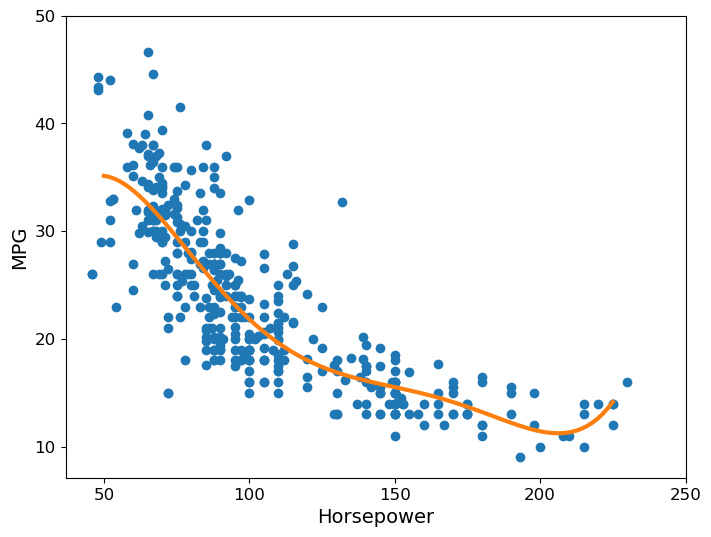

In [18]:
Xnew = DataFrame([hpn.^i for i in 1:10], :auto)
yy5 = MLJ.predict(mtm, Xnew)

figure(figsize = (8, 6))
plot(X.Horsepower, y, ls = "none", marker = "o")
plot(xx.Horsepower, yy5, lw = 3)

xlabel("Horsepower", fontsize = 14)
xticks(50:50:250, fontsize = 12)
yticks(10:10:50, fontsize = 12)
ylabel("MPG", fontsize = 14)
savefig("./plots/3.4.4.png")

In [19]:
mtm = machine(tm, Xhp, y)
fit!(mtm)
rep = report(mtm)

res = rep.plotting

@show round.(res.measurements.^2, digits = 2)
@show argmin(res.measurements)

┌ Info: Training Machine{DeterministicTunedModel{Grid,…},…}.
└ @ MLJBase C:\Users\jeffr\.julia\packages\MLJBase\MuLnJ\src\machines.jl:464
┌ Info: Attempting to evaluate 10 models.
└ @ MLJTuning C:\Users\jeffr\.julia\packages\MLJTuning\Al9yX\src\tuned_models.jl:680
Evaluating over 10 metamodels: 100%[=========================] Time: 0:00:00


round.(res.measurements .^ 2, digits = 2) = [20.91, 27.44, 21.34, 21.24, 88.61, 21.35, 20.91, 223.98, 20.96, 25.66]
argmin(res.measurements) = 7


7

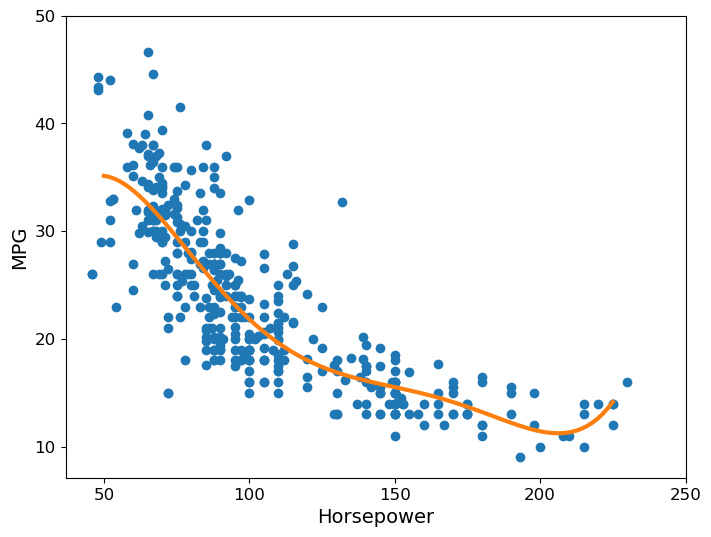

In [20]:
Xnew = DataFrame([hpn.^i for i in 1:10], :auto)
yy7 = MLJ.predict(mtm, Xnew)

figure(figsize = (8, 6))
plot(X.Horsepower, y, ls = "none", marker = "o")
plot(xx.Horsepower, yy7, lw = 3)

xlabel("Horsepower", fontsize = 14)
xticks(50:50:250, fontsize = 12)
yticks(10:10:50, fontsize = 12)
ylabel("MPG", fontsize = 14)
savefig("./plots/3.4.5.png")